# Micronuclei detection
 Automated pipeline to process images. Further details will be add [here](www...)

 This includes
 - predict counts of micronuclei
 - predict masks
 - output a info dictionary with box, center location and size

## set up

Install the packages by cloning this git

In [1]:
using_colab = True

In [2]:
if using_colab:

  # install tool
  %cd /content/
  !git clone https://github.com/kew6688/MicroNuclei_Detection.git
  !pip install -e MicroNuclei_Detection/.
  !pip show mn_segmentation
  %cd /content/MicroNuclei_Detection

/content
Cloning into 'MicroNuclei_Detection'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 513 (delta 121), reused 130 (delta 52), pack-reused 308 (from 1)
Receiving objects: 100% (513/513), 28.13 MiB | 10.89 MiB/s, done.
Resolving deltas: 100% (288/288), done.
Obtaining file:///content/MicroNuclei_Detection
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mn_segmentation (pyproject.toml) ... done
  Created wheel for mn_segmentation: filename=mn_segmentation-0.1.0-py2.py3-none-any.whl size=5157 sha256=37f83257f6a3528ea669f9732f7eb4fcc00ba5cc95825b73491a570f23b218af
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub5kzsfp/wheels/44/d3/d1/353d79dc8f5f434b1d33808323c1d5bb1d136026d7ae0912b8
Successf

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from mn_segmentation.lib.Application import Application
from mn_segmentation.lib.image_crop import show_crop_windows

## Example image

The image is processed in tiles, using ```show_crop_window``` to display how the image is cropped.


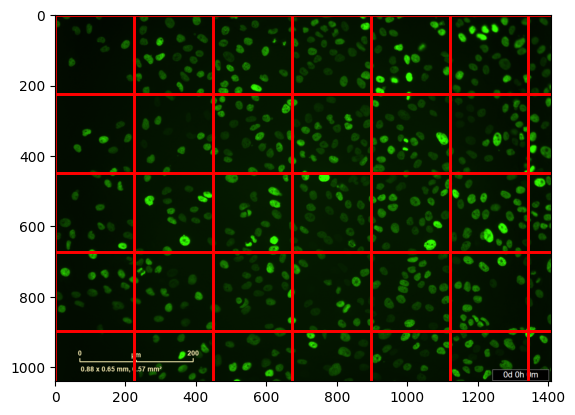

In [4]:
# Load an image using PIL
image_path = 'sample_images/example.tif'
show_crop_windows(image_path=image_path, n_wnd=35, row=5, box_sz=(224,224), stride=(224,224))

## Load model

install the pre trained model weights from huggingface

In [5]:
!git clone https://huggingface.co/kew1046/MaskRCNN-resnet50FPN

Cloning into 'MaskRCNN-resnet50FPN'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (9/9), 3.10 KiB | 1.03 MiB/s, done.


In [6]:
checkpoint_path = "MaskRCNN-resnet50FPN/maskrcnn-resnet50fpn.pt"
app = Application(checkpoint_path)

## Display one prediction

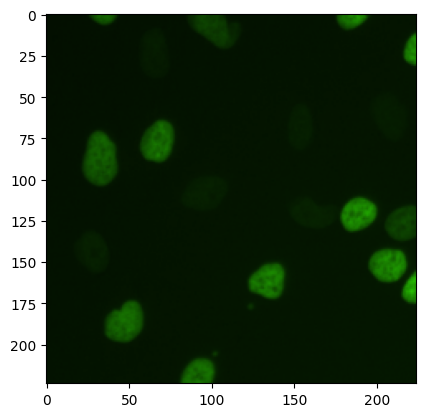

In [7]:
# set the display window size
wnd_sz = 224

# set the location of the window inside image
point = (224,224)

cur_x, cur_y = point
box = (cur_x, cur_y, cur_x + wnd_sz, cur_y + wnd_sz)

# show the image
im = Image.open(image_path)
im = im.crop(box)
plt.imshow(im)
plt.show()

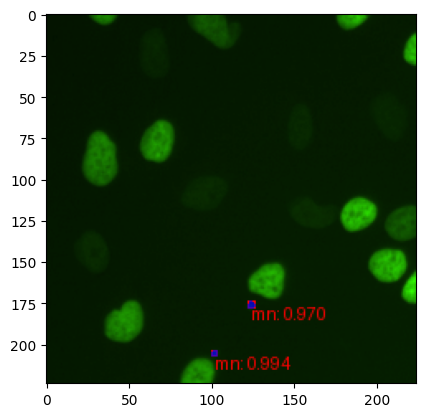

In [8]:
output_image = app.predict_display(image_path,point)
plt.imshow(output_image.permute(1,2,0))
plt.show()

## End to End pipeline
Process the full image with arbitrary size



### Predict mask

predict a mask with all micronuclei pridicted with unique ID from 1 to n. The mask has the same shape to the image.

In [15]:
mask = app.predict_image_mask(image_path)

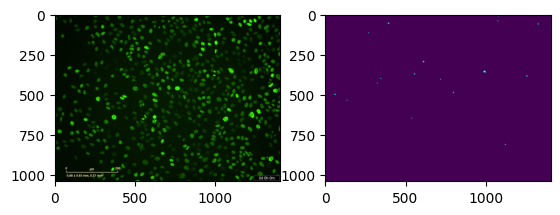

In [10]:
fig, ax = plt.subplots(1,2)
img = Image.open(image_path)
ax[0].imshow(img)
ax[1].imshow(mask>0)
plt.show()

Seperate the mask into isolate micronuclei mask

In [11]:
# skip 0 (background)
obj_ids = np.unique(mask)[1:]
masks = (mask == obj_ids[:, None, None])
print(masks.shape)  # shape [n,w,h], n is the number of masks

(17, 1040, 1408)


### Predict count

count the number of micronuclei inside one image

(In the example image, a footer is added at the bottom of the image. They are ignored by flag ```footer_skip=True```. By default, it is False.

In [16]:
cnt = app.predict_image_count(image_path, footer_skip=True)
print(cnt)

17


### Predict info
each image will return a mn_info dict.
```
mn_info:
{
      "coord": [[x1, y1],...],   `# list of center coordinates
      "area": [x,...],        # list of mask area
      "bbox": [...],         # list of bounding box,
                        for mn bbox: (xmin, ymin, xmax, ymax)
                        for nuc bbox: (x, y, w, h)
}
```

In [17]:
mn_info = app.predict_image_info(image_path, footer_skip=True)
print(mn_info)

{'coord': [[395, 56], [271, 115], [1079, 9], [1077, 41], [1328, 61], [325, 429], [348, 400], [613, 295], [557, 371], [719, 405], [994, 357], [1257, 385], [61, 499], [137, 536], [539, 647], [800, 488], [1123, 811]], 'area': [55.436683654785156, 16.217918395996094, 43.07221984863281, 18.773401260375977, 31.698833465576172, 16.473743438720703, 20.695709228515625, 51.25682067871094, 40.681095123291016, 18.73752784729004, 140.94630432128906, 40.10343933105469, 43.549781799316406, 15.128105163574219, 15.918415069580078, 37.124088287353516, 31.098064422607422], 'bbox': [[392, 53, 399, 59], [269, 114, 273, 117], [1076, 7, 1082, 12], [1075, 40, 1080, 43], [1326, 59, 1331, 64], [324, 428, 327, 431], [346, 398, 350, 402], [610, 292, 617, 299], [555, 369, 560, 374], [718, 404, 721, 407], [987, 352, 1001, 363], [1254, 383, 1260, 388], [58, 497, 65, 502], [135, 535, 139, 538], [537, 646, 541, 649], [798, 485, 802, 491], [1121, 809, 1126, 813]]}
